In [1]:
from google.colab import files
files.upload()  # Upload kaggle.json here


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chinnu0022","key":"dbe491fbf5e393762d46686f8cc7613f"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
# Download the dataset from Kaggle
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification


Dataset URL: https://www.kaggle.com/datasets/sriramr/fruits-fresh-and-rotten-for-classification
License(s): unknown
 99% 3.55G/3.58G [00:19<00:00, 238MB/s]
100% 3.58G/3.58G [00:20<00:00, 192MB/s]


In [4]:
import zipfile

# Unzip the downloaded dataset
with zipfile.ZipFile("fruits-fresh-and-rotten-for-classification.zip", "r") as zip_ref:
    zip_ref.extractall("fruits_data")


In [5]:
import os

# List class folders
base_path = "fruits_data/dataset"
print("Classes:", os.listdir(base_path))


Classes: ['test', 'train', 'dataset']


In [6]:
train_dir = os.path.join(base_path, 'train')
test_dir = os.path.join(base_path, 'test')


In [9]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# ==== 1. Directory setup ====
#train_dir = '/content/dataset/training_set'
#test_dir = '/content/dataset/validation_set'
model_path = '/content/best_model.keras'

# ==== 2. Config ====
img_size = 224
batch_size = 32
num_classes = 6 # Changed to 6 to match the number of classes in the data

# ==== 3. Data Preprocessing ====
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

# ==== 4. Load Pretrained ResNet50 ====
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# ==== 5. Custom Classifier ====
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# ==== 6. Compile Model (Initial Training) ====
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ==== 7. Initial Training (Top Layers Only) ====
model.fit(
    train_data,
    epochs=5,
    validation_data=test_data
)

# ==== 8. Unfreeze some base layers for fine-tuning ====
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True

# ==== 9. Compile Again for Fine-Tuning ====
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ==== 10. Callbacks to Prevent Overfitting ====
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, verbose=1)

# ==== 11. Final Training (Fine-Tuning) ====
model.fit(
    train_data,
    epochs=15,
    validation_data=test_data,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

# ==== 12. Load Best Model ====
best_model = load_model(model_path)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 540ms/step - accuracy: 0.2292 - loss: 1.8746

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


341/341 ━━━━━━━━━━━━━━━━━━━━ 226s 615ms/step - accuracy: 0.2293 - loss: 1.8742 - val_accuracy: 0.3595 - val_loss: 1.5811
Epoch 2/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 195s 571ms/step - accuracy: 0.3036 - loss: 1.6419 - val_accuracy: 0.3903 - val_loss: 1.4947
Epoch 3/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 201s 568ms/step - accuracy: 0.3293 - loss: 1.5864 - val_accuracy: 0.3751 - val_loss: 1.4686
Epoch 4/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 200s 562ms/step - accuracy: 0.3402 - loss: 1.5577 - val_accuracy: 0.3795 - val_loss: 1.4499
Epoch 5/5
341/341 ━━━━━━━━━━━━━━━━━━━━ 194s 569ms/step - accuracy: 0.3528 - loss: 1.5353 - val_accuracy: 0.4285 - val_loss: 1.4391
Epoch 1/15
341/341 ━━━━━━━━━━━━━━━━━━━━ 0s 563ms/step - accuracy: 0.3659 - loss: 2.0360
Epoch 1: val_loss improved from inf to 1.11967, saving model to /content/best_model.keras
341/341 ━━━━━━━━━━━━━━━━━━━━ 237s 629ms/step - accuracy: 0.3661 - loss: 2.0344 - val_accuracy: 0.5415 - val_loss: 1.1197 - learning_rate: 1.0000e-04
Epoch 2/15
341/341 ━━━━━━━━━

In [10]:
loss, acc = best_model.evaluate(test_data)
print(f"Test Accuracy: {acc:.2f}")


85/85 ━━━━━━━━━━━━━━━━━━━━ 23s 198ms/step - accuracy: 0.8993 - loss: 0.2959
Test Accuracy: 0.89


In [11]:
#Step: Add Grad-CAM Visualization for Model Interpretability

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted: rottenapples (84.40%)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


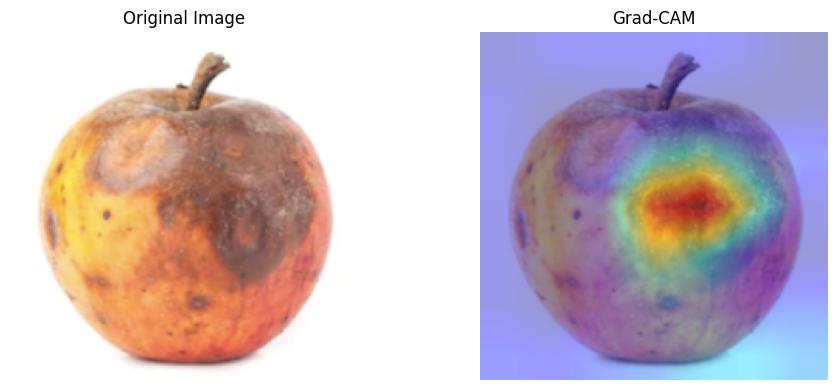

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2

# Load your best model
model = tf.keras.models.load_model('/content/best_model.keras')

# Select a test image path
img_path = '/content/fruits_data/dataset/test/rottenapples/Screen Shot 2018-06-07 at 2.15.34 PM.png'  # <-- update with any test image

# Preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Get predictions
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
class_names = list(test_data.class_indices.keys())

print(f"Predicted: {class_names[predicted_class]} ({preds[0][predicted_class]*100:.2f}%)")

# Grad-CAM Logic
grad_model = Model(
    inputs=model.inputs,
    outputs=[model.get_layer("conv5_block3_out").output, model.output]  # Last conv layer in ResNet50
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

# Multiply each channel by importance
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Display heatmap on image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Plot result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


In [15]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving sample1.jpeg to sample1.jpeg


{'sample1.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x13\x12\x15\x13\x13\x13\x16\x16\x15\x17\x17\x18\x17\x18\x17\x17\x15\x15\x15\x19\x15\x18\x18\x17\x16\x1a\x16\x1a\x17\x18\x1a\x1d( \x1a\x1a%\x1f\x18\x15!3"%)+...\x18\x1f383-7(-.+\x01\n\n\n\x0e\r\x0e\x1b\x10\x10\x1b-%\x1f\x1f----/+-----------------------+-------+------------\xff\xc0\x00\x11\x08\x00\xc3\x01\x02\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1c\x00\x01\x00\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x04\x05\x02\x03\x06\x01\x07\x08\xff\xc4\x00<\x10\x00\x01\x03\x02\x04\x03\x06\x04\x04\x04\x05\x05\x00\x00\x00\x00\x01\x00\x02\x11\x03!\x04\x121A\x05Qa\x06"q\x81\x91\xa1\x13\xb1\xc1\xf02BR\xe1\x14b\xd1\xf1\x07#3r\xa2\x15\x82\x92\xb2\xd2\xff\xc4\x00\x1a\x01\x01\x00\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00"\x11\x01\x00\x02\x02\x02\x02\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted: rottenapples (76.34%)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


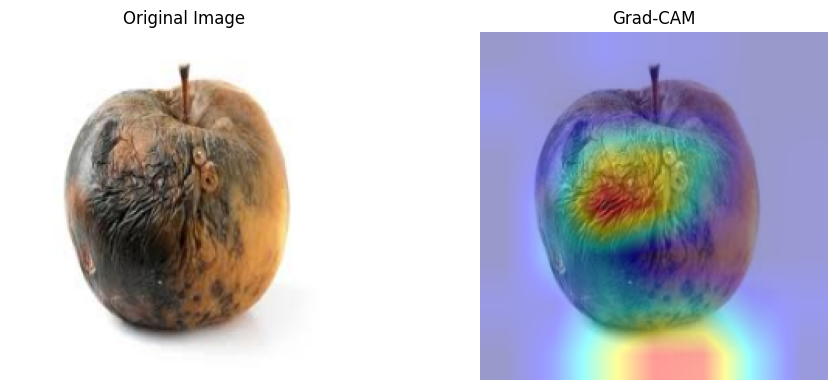

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2

# Load your best model
model = tf.keras.models.load_model('/content/best_model.keras')

# Select a test image path
img_path = '/content/sample1.jpeg'  # <-- update with any test image

# Preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Get predictions
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
class_names = list(test_data.class_indices.keys())

print(f"Predicted: {class_names[predicted_class]} ({preds[0][predicted_class]*100:.2f}%)")

# Grad-CAM Logic
grad_model = Model(
    inputs=model.inputs,
    outputs=[model.get_layer("conv5_block3_out").output, model.output]  # Last conv layer in ResNet50
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

# Multiply each channel by importance
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Display heatmap on image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Plot result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


In [17]:
from google.colab import files
files.upload()  # Upload kaggle.json here

Saving sample.jpeg to sample.jpeg


{'sample.jpeg': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00\x84\x00\t\x06\x07\x12\x13\x10\x15\x10\x10\x10\x10\x15\x15\x15\x15\x15\x17\x17\x16\x15\x17\x17\x15\x15\x12\x17\x17\x16\x18\x16\x16\x15\x15\x17\x18\x1d( \x18\x1a%\x1d\x13\x17!1!%)+...\x17\x1f383,7(-.+\x01\n\n\n\x0e\r\x0e\x1a\x10\x10\x1a/% &/-55-----5------+-+------0------+----+-----------+\xff\xc0\x00\x11\x08\x00\xb7\x01\x13\x03\x01"\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1b\x00\x01\x00\x02\x03\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x05\x03\x04\x06\x02\x07\xff\xc4\x00:\x10\x00\x01\x03\x02\x04\x04\x02\t\x03\x04\x01\x05\x01\x00\x00\x00\x01\x00\x02\x11\x03!\x04\x121A\x05"Qaq\x91\x06\x132B\x81\xa1\xb1\xe1\xf0\x14R\xc1b\x82\xd1\xf1#3r\x92\xa2\xb2\x17\xff\xc4\x00\x1a\x01\x01\x01\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x03\x04\x05\x06\xff\xc4\x00,\x11\x01\x00\x02\x02\x01\x04\x01\x01\x07\x05\x01\x00\x00\x00\x00\x00\x00\x01\x02\x03\x11\x04\x12!1QA\x05\x

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted: rottenoranges (99.06%)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


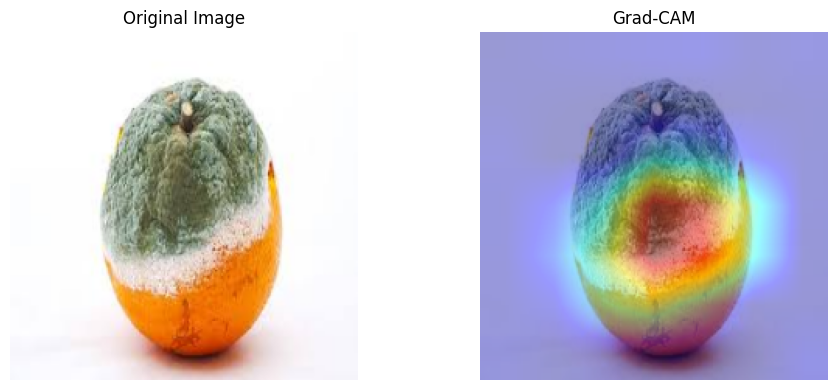

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import cv2

# Load your best model
model = tf.keras.models.load_model('/content/best_model.keras')

# Select a test image path
img_path = '/content/sample.jpeg'  # <-- update with any test image

# Preprocess image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Get predictions
preds = model.predict(img_array)
predicted_class = np.argmax(preds[0])
class_names = list(test_data.class_indices.keys())

print(f"Predicted: {class_names[predicted_class]} ({preds[0][predicted_class]*100:.2f}%)")

# Grad-CAM Logic
grad_model = Model(
    inputs=model.inputs,
    outputs=[model.get_layer("conv5_block3_out").output, model.output]  # Last conv layer in ResNet50
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:, predicted_class]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
conv_outputs = conv_outputs[0]

# Multiply each channel by importance
heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

# Display heatmap on image
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))
heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# Plot result
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.tight_layout()
plt.show()


In [20]:
model.save("final_rotten_fruit_model.keras")


In [21]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = load_model("final_rotten_fruit_model.keras")

# Test with one sample image again
img_path = "/content/fruits_data/dataset/test/freshapples/Screen Shot 2018-06-08 at 5.32.50 PM.png"  # Change this to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction) * 100

print(f"Predicted: {predicted_class} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted: freshapples (70.63%)


In [22]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the saved model
model = load_model("final_rotten_fruit_model.keras")

# Test with one sample image again
img_path = "/content/fruits_data/dataset/test/rottenbanana/Screen Shot 2018-06-12 at 8.47.41 PM.png"  # Change this to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Predict
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction) * 100

print(f"Predicted: {predicted_class} ({confidence:.2f}%)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted: rottenbanana (100.00%)


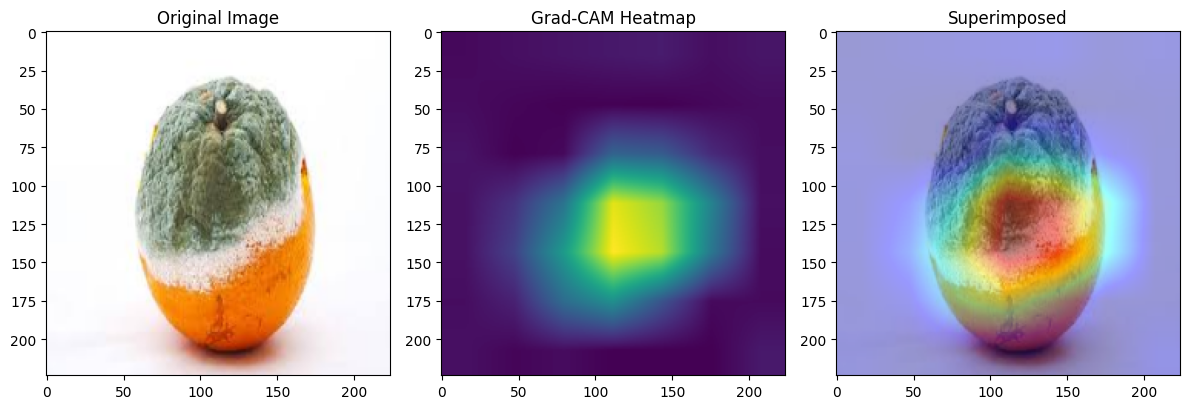

In [27]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

# Load image
img_path = "/content/sample.jpeg"  # Change this to your test image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array_exp = np.expand_dims(img_array, axis=0)

# Define model and last convolutional layer (ResNet50)
last_conv_layer_name = "conv5_block3_out"  # for ResNet50
grad_model = Model(
    inputs=model.input,
    outputs=[model.get_layer(last_conv_layer_name).output, model.output]
)

# Compute gradient of the top predicted class
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array_exp)
    pred_index = tf.argmax(predictions[0])
    pred_output = predictions[:, pred_index]

# Compute gradients of prediction w.r.t. last conv layer output
grads = tape.gradient(pred_output, conv_outputs)[0]

# Mean intensity of gradients over each feature map channel
pooled_grads = tf.reduce_mean(grads, axis=(0, 1)) # Modified this line

# Multiply each channel in feature map array by "importance" of that channel
conv_outputs = conv_outputs[0]
# Reshape pooled_grads to have two dimensions before matrix multiplication
heatmap = conv_outputs @ pooled_grads[:, tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Normalize between 0 and 1
heatmap = np.maximum(heatmap, 0) / np.max(heatmap)

# Load original image using OpenCV
img_cv = cv2.imread(img_path)
img_cv = cv2.resize(img_cv, (224, 224))

# Resize heatmap to match image size and convert to color map
heatmap_resized = cv2.resize(heatmap, (224, 224))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

# Superimpose heatmap onto original image
superimposed_img = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)

# Show results
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='viridis')
plt.title("Grad-CAM Heatmap")

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title("Superimposed")

plt.tight_layout()
plt.show()

In [28]:
from google.colab import files
files.download("best_model.keras")  # or "best_model.h5" if that's what you saved


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>